# cmbpy

Generating realizations of a 2d Gaussian random field $\phi(x)$, with some simple analysis run on the position space results.

Inspired by the [Cosmic Microwave Background (CMB)](https://en.wikipedia.org/wiki/Cosmic_microwave_background); see [my website](https://garrettgoon.com/gaussian-fields/) for more background information.

TODO:

- Extend to higher dimensions
- Some systematic errors seem to still exist in the position space computation, maybe due to missing $\frac{2\pi}{N}$ factors?

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats
import corner
import time
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.signal import correlate2d

A class for generating power spectra is below.

Spectra are characterized by an amplitude and power-law exponent: $\langle \phi(k)\phi(-k)\rangle'=\frac{\texttt{amplitude}}{k^{\texttt{power}}}\equiv P(k)$, corresponding in position space to $\langle \phi(x)\phi(0)\rangle\propto \frac{\texttt{amplitude}}{x^{d-{\texttt{power}}}}\equiv G(x)$ in $d$-dimensions. 

Important parameters:

- `amplitude`: amplitude of spectrum, defined above.
- `power`: power-law exponent, defined above.
- `dimensions`: number of spatial dimensions (can only use `dimensions`=2, currently).
- `size_exponent`: grid size is 2**`size_exponent`.
    
Methods:

- `generate`: generate realization of desired power spectrum.
- `show_x_realization`: visualization of generated spectra.
- `compute_auto_corrs`: calculating $k$- and $x$-space correlation functions.
- `plot_k_spectrum`: Plot $k$-space spectrum against theory and a least-squared fit.
- `plot_x_spectrum`: Plot $x$-space spectrum against theory and a least-squared fit.
- `hist`: histogram of generated values (should be normally distributed; mostly a sanity check).
- `bayes`: simple Bayesian/MCMC analysis on `amplitude` and `power` parameters using flat priors

In [197]:
class CmbPy():
    """
    A class for generating 2D power specta and some analysis of the results.

    Description
    ----------

    Found the below useful for this computation:
    https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

    Args
    ----------
    `amplitude`: float, default = 1.
        Amplitude of the momentum-space power spectrum.
    `power`: float, default = 1.75
        Exponent of k in the denominator of momentum-space power spectrum.
    `size_exponent`: int, default = 5
        Sets the grid size to be N = 2 ** size_exponent.
    `dimensions`: int, default = 2
        Number of space dimensions, currently only dimensions = 2 is implemented.
    """

    def __init__(self, amplitude=1., power=1.75, size_exponent=5, dimensions=2):
        self.amplitude = amplitude
        self.power = power
        self._size = int(2 ** size_exponent)
        if dimensions != 2:
            raise NotImplementedError(
                'dimensions != 2 has not yet been implemented.')
        self.dimensions = dimensions

        # If P(k)=amplitude/k^{power}, then the corresponding position-space correlator
        # is G(x)=_x_amplitude/x^{dims-power} with _x_amplitude as below.
        self._x_amplitude_numerator = self.amplitude * \
            gamma(1 - (self.power / 2)) / (2 * np.pi / self._size) ** 2
        self._x_amplitude_denominator = (
            np.pi * (2 ** self.power)) * gamma(self.power / 2)

    def generate(self):
        """Generating the spectrum.
        """
        # Creating a grid w/ each point pulled from std normal.
        gaussian_seed = np.random.normal(
            size=[self._size for _ in range(self.dimensions)])
        # Numpy's fft algorithm automatically indexes with negative values on right half
        # positive on left half, as desired.
        gaussian_seed_fourier = np.fft.fft2(gaussian_seed)

        # Generating the fft momenta indices and their norms.
        kvector = np.fft.fftfreq(self._size) * self._size
        kx, ky = np.meshgrid(kvector, kvector, indexing='ij')
        knorms = np.sqrt(kx ** 2 + ky ** 2)
        # Regulate the k=0 divergence, if necessary.
        if self.power > 0:
            knorms[0, 0] = np.inf
        self._knorms = knorms
        # Create a similar spatial grid for later use.
        xvector = np.arange(-self._size + 1, self._size)
        xx, yy = np.meshgrid(xvector, xvector, indexing='ij')
        xnorms = np.sqrt(xx ** 2 + yy ** 2)
        if self.dimensions - self.power > 0:
            xnorms_mid = len(xvector) // 2
            xnorms[xnorms_mid, xnorms_mid] = np.inf
        self._xnorms = xnorms

        # Generate the realizations in k- and x-space
        power_spectrum = self.amplitude * ((knorms) ** (-1 * self.power))
        power_spectrum_sqrt = np.sqrt(power_spectrum)
        self._k_realization = gaussian_seed_fourier * power_spectrum_sqrt
        # Transform back and take the real part to get the spectrum.
        self._x_realization = np.real(np.fft.ifft2(self._k_realization))
        # Imaginary parts should be from numerical errors and extremely small.
        abs_im_to_re_ratio = np.abs(np.imag(np.fft.ifft2(self._k_realization)) / np.real(
            np.fft.ifft2(self._k_realization))).mean()
        # The mean should also be nearly zero.  Sanity check both
        assert abs_im_to_re_ratio < 1e-10, 'Sanity check failed: ratio of imaginary to real parts > 1e-10'
        assert self._x_realization.mean(
        ) < 1e-10, 'Sanity check failed: mean of position-space realization > 1e-10'

    def compute_auto_corrs(self):
        """Compute autocorrelation matrices and power spectra.
        """
        self._k_auto_corr = (np.abs(self._k_realization)
                             ** 2) / ((self._size) ** self.dimensions)
        self._k_power_spectrum, self._k_coord_mags, self._k_power_stds = self._bin_auto_corr(
            self._k_auto_corr, self._knorms)

        self._x_auto_corr = correlate2d(
            self._x_realization, self._x_realization, mode='full', boundary='wrap')
        self._x_power_spectrum, self._x_coord_mags, self._x_power_stds = self._bin_auto_corr(
            self._x_auto_corr, self._xnorms)

    def plot_k_spectrum(self):
        """Performs a simple plot of the momentum-space spectrum (linear and log-log),
        along with a simple linear regression fit as a sanity check.
        """
        self._power_spectrum_plotter(
            self._k_power_spectrum, self._k_coord_mags, self._k_power_stds, space='momentum')

    def plot_x_spectrum(self):
        """Performs a simple plot of the position-space spectrum (linear and log-log),
        along with a simple linear regression fit as a sanity check.
        """
        self._power_spectrum_plotter(
            self._x_power_spectrum, self._x_coord_mags, self._x_power_stds, space='position')

    def show_x_realization(self):
        """Visualize the position-space realization.
        """
        if not hasattr(self, '_x_realization'):
            return print('Run generate to create spectrum first')

        fig, ax = plt.subplots()
        ax.imshow(self._x_realization, cmap='inferno')
        fig.suptitle('Realization')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    def hist(self):
        """Histogram of generated values.
        """
        if not hasattr(self, '_x_realization'):
            return print('Run generate to create spectrum first')

        data = self._x_realization.flatten()
        std = np.std(data)
        self.std = std

        _, ax = plt.subplots()
        ax.hist(data, bins=100, density=True)
        ax.set_ylabel('counts')
        ax.set_xlabel('$\phi$')
        ax.set_title('Distribution of generated points')
        # plot fit
        x = np.linspace(-5 * std, 5 * std, 100)
        y = stats.norm.pdf(x, 0, std)
        ax.plot(x, y, label=f'Normal(0,{std**2:.3f})')
        plt.legend()

    def bayes(self, steps=10**4, walkers=2**6):
        """
        Bayesian analysis for power-spectrum parameters using binned data.
        """
        # Set flat priors on the amplitude and power over some range covering actual values.
        amp_max, power_max = 10 * self.amplitude, 5

        def log_prior(params):
            amplitude, power = params
            if 0 < amplitude < amp_max and 0 < power < power_max:
                return 0.0
            return -np.inf

        def log_likelihood(params, data):
            x, y, sigy = data
            return np.sum(-np.log(sigy) - .5 *
                          (self._x_spectrum_theory(x, params) - y)**2 / sigy**2)

        # Total log-prob needed for MCMC.
        def log_posterior(params, data):
            lp = log_prior(params)
            if not np.isfinite(lp):
                return -np.inf
            return lp + log_likelihood(params, data)

        # MCMC setup.
        # Distribute initial walker positions around position space LR best fits (so as not to cheat).
        initial = np.array([np.random.uniform(0, amp_max),
                            np.random.uniform(0, power_max)])
        pos = initial.T + .1 * np.concatenate(
            (np.random.uniform(-initial[0], initial[0], (walkers, 1)),
             np.random.uniform(-initial[1], initial[1], (walkers, 1))),
            axis=1)
        walkers, dim = pos.shape
        sampler_args = np.array(list(zip(self._x_coord_mags,
                                         self._x_power_spectrum,
                                         self._x_power_stds)))
        sampler = emcee.EnsembleSampler(walkers,
                                        dim,
                                        log_posterior,
                                        args=[sampler_args.T])
        sampler.run_mcmc(pos, steps, progress=True)
        samples = sampler.get_chain()

        # Plotting chain convergencelr_fit
        fig, axs = plt.subplots(2)
        for i in range(walkers):
            for j in range(dim):
                axs[j].plot(samples[:, i, j])

        axs[0].set_ylabel('amp')
        axs[1].set_ylabel('power')
        fig.suptitle('Chain convergence')

        # Autocorrelation analysis.
        auto_corr = sampler.get_autocorr_time()
        thin_rate = int(np.mean(np.array(auto_corr)) / 2)

        # Burn 1/4 of data, then make corner plots.
        flat_samples = sampler.get_chain(discard=int(steps / 4),
                                         thin=thin_rate,
                                         flat=True)

        fig = corner.corner(flat_samples,
                            labels=['amp', 'power'],
                            truths=[self.amplitude, self.power],
                            truth_color='r')
        fig.suptitle(
            f'Actual values: (amp, power) = ({self.amplitude:.3f}, {self.power:.3f})'
        )

    # Helper functions below.
    # -----------------------------------------------

    def _k_spectrum(self, k, params=None):
        """Returns the theoretical position-space correlator G(x), given the model
        parameters. Only valid for 2d right now. Fourier transform to position space is
        unambiguous for 2 > power > .5. Used for fitting. 
        """
        if params is None:
            amplitude = self.amplitude
            power = self.power
        else:
            amplitude, power = params

        return amplitude / k ** power

    def _x_spectrum_theory(self, x, params=None):
        """Returns the theoretical position-space correlator G(x), given the model
        parameters. Only valid for 2d right now. Fourier transform to position space is
        unambiguous for 2 > power > .5. Used for fitting. 

        Might be missing some (2 pi / N)  factors?
        """
        if params is None:
            numerator = self._x_amplitude_numerator
            denominator = self._x_amplitude_denominator
            power = self.power
        else:
            amplitude, power = params
            numerator = amplitude * \
                gamma(1 - (power / 2)) / (2 * np.pi / self._size) ** 2
            denominator = (np.pi * (2 ** power)) * gamma(power / 2)

        return (numerator / denominator) * (x ** (power - self.dimensions))

    def _bin_auto_corr(self, corr, coord_norms):
        # Flatten out and bin.
        corr_flat = corr.flatten()
        coord_norms_flat = coord_norms.flatten()
        coord_bins = np.arange(.5, len(coord_norms) // 2 + 1, 1)
        coord_means = 0.5 * (coord_bins[1:] + coord_bins[:-1])
        corr_binned_means, _, _ = stats.binned_statistic(coord_norms_flat,
                                                         corr_flat,
                                                         statistic='mean',
                                                         bins=coord_bins)
        corr_binned_stds, _, _ = stats.binned_statistic(coord_norms_flat,
                                                        corr_flat,
                                                        statistic='std',
                                                        bins=coord_bins)

        # In order to perform a power-law linear regression fit on the binned values,
        # we need to take a logarithm which requires all binned values to be positive,
        # while some are negative at large k, presumably due to low statistics.
        # As a bit of a fudge, we isolate the terms in corr_binned_means which are positive.
        corr_binned_means_first_neg_index = -1
        for index, num in enumerate(corr_binned_means):
            if num < 0:
                corr_binned_means_first_neg_index = index
                break
        corr_binned_means_truncated = corr_binned_means[:
                                                        corr_binned_means_first_neg_index]
        coord_means_truncated = coord_means[:corr_binned_means_first_neg_index]
        corr_binned_stds_truncated = corr_binned_stds[:
                                                      corr_binned_means_first_neg_index]
        return corr_binned_means_truncated, coord_means_truncated, corr_binned_stds_truncated

    def _power_spectrum_plotter(self,
                                corr_binned_means,
                                coord_means,
                                corr_binned_stds,
                                space):
        """Performs a simple plot of the generic power spectra (linear and log-log),
        along with a simple linear regression fit.

        Description
        ----------

        Takes in the binned means, corresponding bin coordinate values, and the stds of
        the means and return the appropriate plot for either position or momentum space.

        Args
        ----------
        `corr_binned_means`: array
            Path to data csv file.
        `coord_means`: str
            Path to character csv file
        `corr_binned_stds`: str or int, default = 'title'
            Column in data csv file containing text, e.g. `'abstract'`
        or `'abstract'`
        `space`: 'momentum' or 'position'
            Whether to plot k- or x-space results.

        Returns 
        ----------
        `tuple`
            Returns `(text_tensor, source_int)`  where `text_tensor` is the
            one-hot encoded text and `source_int` is 0, 1 if from `'vixra'`,
            `'arxiv'`.

        Raises
        ------
        `KeyError`
            when a key error
        `OtherError`
            when an other error
        """
        assert space in (
            'momentum', 'position'), "space must be one of ('momentum', 'position')."

        # Simple linear regression.
        spectrum_lr = stats.linregress(np.log(1 / (coord_means)),
                                       np.log(np.abs(corr_binned_means)))
        # Helper function for plotting.

        def spectrum_lr_fit(x):
            return np.exp(spectrum_lr.intercept) / (x ** (spectrum_lr.slope))

        # Plotting.
        fig, (ax_lin, ax_log) = plt.subplots(2)
        # Binned data.
        ax_lin.errorbar(coord_means,
                        corr_binned_means, yerr=corr_binned_stds)
        ax_log.loglog(coord_means, corr_binned_means)
        # Fit results.
        x_fit = np.linspace(
            coord_means[0], coord_means[-1], num=100)
        y_fit = spectrum_lr_fit(x_fit)
        ax_lin.plot(x_fit,
                    y_fit,
                    linestyle='-',
                    color='r',
                    label='linear-regression')
        ax_log.loglog(x_fit,
                      y_fit,
                      linestyle='-',
                      color='r',
                      label='linear-regression')
        # Theory results.
        if space == 'position':
            y_theory = self._x_spectrum_theory(x_fit)
            xlabel = 'x'
            ylabel = 'G(x)'
            theory_amplitude = self._x_amplitude_numerator / self._x_amplitude_denominator
            theory_power = self.dimensions - self.power
        else:
            y_theory = self._k_spectrum(x_fit)
            xlabel = 'k'
            ylabel = 'P(k)'
            theory_amplitude = self.amplitude
            theory_power = self.power
        ax_lin.plot(x_fit,
                    y_theory,
                    linestyle='--',
                    color='g',
                    label='theory')
        ax_log.loglog(x_fit,
                      y_theory,
                      linestyle='--',
                      color='g',
                      label='theory')
        # Plot labels.
        ax_lin.set_xlabel(xlabel)
        ax_lin.set_ylabel(ylabel)
        ax_log.set_xlabel(f'$\ln {xlabel}$')
        ax_log.set_ylabel(f'$\ln {ylabel}$')
        ax_log.set_title(
            f'${ylabel}^{{fit}}\\approx  {np.exp(spectrum_lr.intercept):.3f}\\cdot {xlabel}^{{{-1*spectrum_lr.slope:.3f}}} \\quad {ylabel}^{{theory}}\\approx  {theory_amplitude:.3f}\\cdot {xlabel}^{{{-theory_power:.3f}}} $'
        )
        plt.tight_layout()
        plt.legend()


Run a realization and analyze.  Choose the amplitude and power randomly.

The momentum space correlator $P(k)=\frac{\texttt{amplitude}}{k^{\texttt{power}}}$ only unambiguously defines a position-space correlator $G(x)$ for $2>{\texttt{power}}>1/2$ (other values require regularization/analytic continuation; [relevant integral can be found here](https://dlmf.nist.gov/10.22#E43)).  The precise form of is $G(x)=\frac{\texttt{ amplitude}\,\Gamma[1-\texttt{power}/2]}{2^\texttt{power}x^{2-\texttt{power}}\,\Gamma[{\texttt{power}}/2]}$.

In [198]:
rand_amp= np.random.uniform(0, 10,1)[0]
rand_power = np.random.uniform(.75, 1.75, 1)[0]
rand_amp = rand_power = 1.
size_exponent = 8
print(f'amplitude: {rand_amp:.3f}',
      f'power: {rand_power:.3f}',
      f'size: {2 ** size_exponent}',
      sep='\n')
# Create an instance, generate the realization, 
# and compute the autocorrelation functions.
c = CmbPy(size_exponent=size_exponent, amplitude=rand_amp, power=rand_power)
c.generate()
c.compute_auto_corrs()

The realization in position space:

In [ ]:
c.show_x_realization()

Run generate to create spectrum first


Plot the $k$- and $x$-space spectrum (lin and log-log) against theory and linear-regression fit.

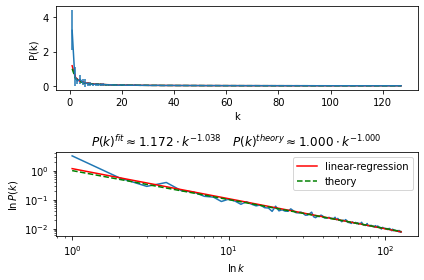

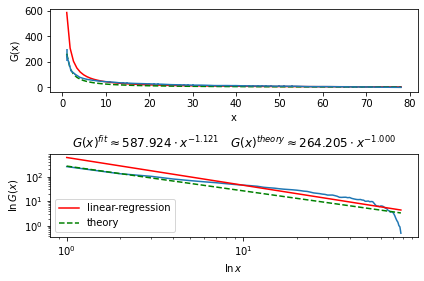

In [ ]:
c.plot_k_spectrum()
c.plot_x_spectrum()

Histogram of field values against the a fit Gaussian:

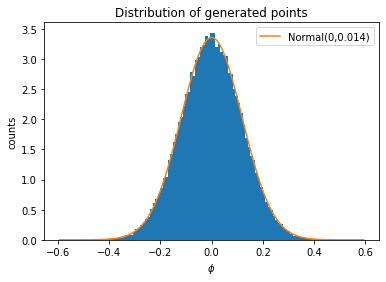

In [ ]:
c.hist()

  0%|          | 0/10000 [00:00<?, ?it/s]/home/garrett/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:31<00:00, 318.90it/s]


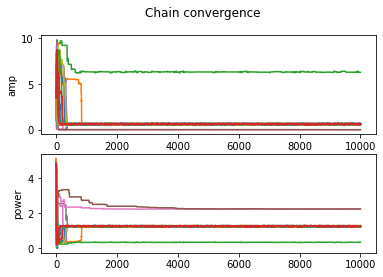

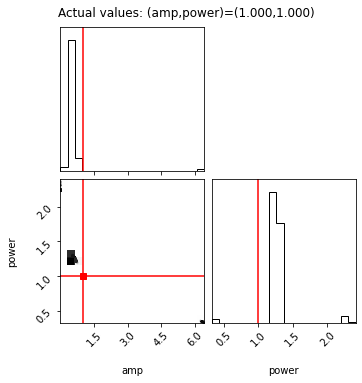

In [ ]:
c.bayes(steps=10**4, walkers=64)